* Text classfification is the task of assigning some label or class to some input text.
* `Applications`: Sentiment analysis, intent detection, language detection etc.

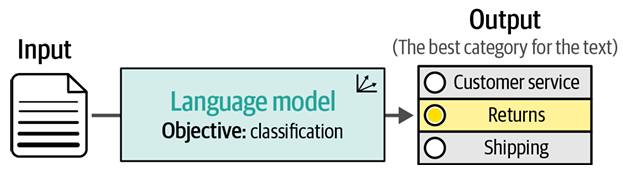

Two types of models can be used:
1. representative models
2. Generative models

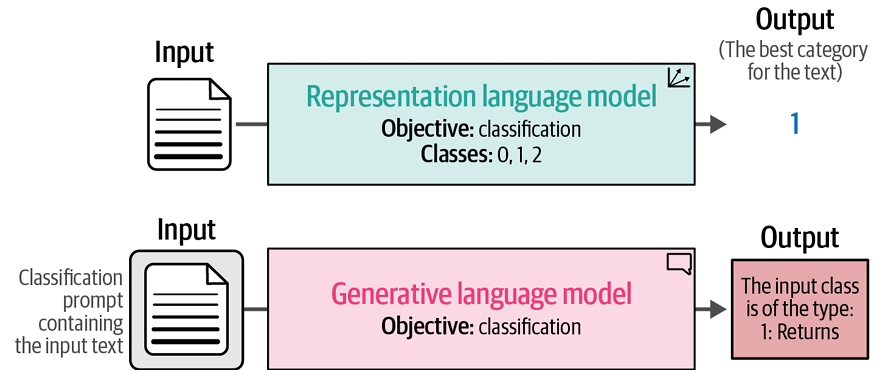

In [4]:
from datasets import load_dataset

In [6]:
# rotten tomatoes movie revvew dataset
data = load_dataset("rotten_tomatoes")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [21]:
# data exploration
data["train"][0,1] # given as [movie number, review number]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .'],
 'label': [1, 1]}

# 1. Text classification with Representation models

Done by fine tuning,
* task specific model - representation mdoel trained for specific task
* Embedding model - embedding model that can be later used for any task by attaching a head.

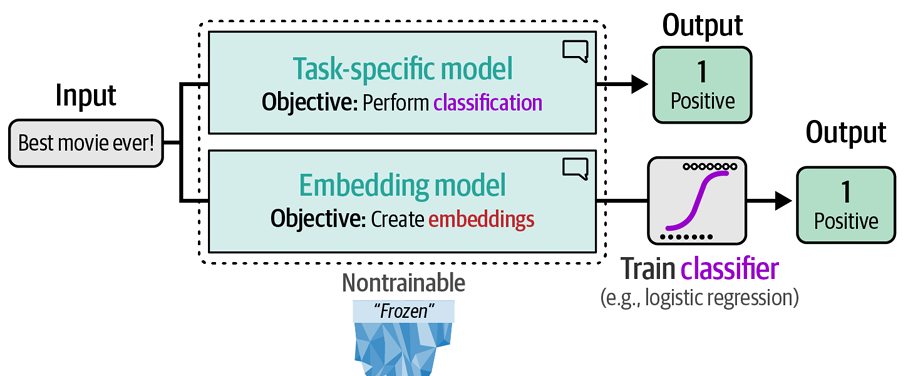

## a. Model Selection:

* There are about 60k model for text classification and 8k embedding models. Therefore choosing the best one is an art.
* The model we use,
  1. Task specific model - RoBERTa, a model fine tuned on tweets for sentiment analysis.
  2. Senetence embeedding - all mpnet base v2 model

### i. using task specific model

In [32]:
from transformers import pipeline
import torch
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [28]:
# model path
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# load model and tokenizer
pipe = pipeline(model=model_path,
               tokenizer=model_path,
               return_all_scores=True,
               device=DEVICE)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [47]:
# test the generalisation ability of the model - test w/o fine tuning for rotten tomatoes data
y_pred = []

for output in tqdm(pipe(KeyDataset(data["test"], "text")), 
                   total=len(data["test"])):
    negative_score = output[0]["score"]
    positive_score = output[2]["score"]

    sentiment = torch.argmax(torch.tensor([negative_score, positive_score]))
    y_pred.append(sentiment)

100%|██████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:12<00:00, 82.50it/s]


In [49]:
from sklearn.metrics import classification_report

# model evaluation
def accuracy(y_true, y_pred):
    performace = classification_report(y_true=y_true,
                                      y_pred=y_pred,
                                      target_names=["negative Review", "positive Review"])
    print(performace)

`precision`: tells how many items found are relevant

`recall`: tells how many relevant classes were found

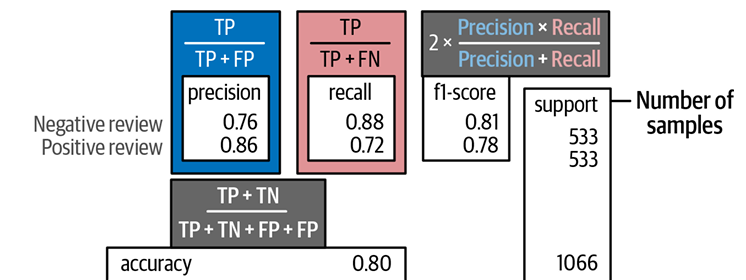

We can see that the model is producing very good results already.

### ii. using embedding model
Used if task specific model is not available. 
* Don't fine tune represntation modle ourselves as it is of high computational cost.
* Use general purpose embedding model by attaching the classifier.

In [52]:
from sentence_transformers import SentenceTransformer

In [54]:
# load model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [55]:
# convert text to embedding
train_embed = model.encode(data["train"]["text"], show_progress_bar=True)
test_embed = model.encode(data["test"]["text"], show_progress_bar=False)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 267/267 [00:19<00:00, 13.95it/s]


In [59]:
# lets use logistic regression for classification
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
clf.fit(train_embed, data["train"]["label"])

LogisticRegression(random_state=42)

In [60]:
# prediction
y_pred = clf.predict(test_embed)

accuracy(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

negative Review       0.85      0.86      0.85       533
positive Review       0.86      0.85      0.85       533

       accuracy                           0.85      1066
      macro avg       0.85      0.85      0.85      1066
   weighted avg       0.85      0.85      0.85      1066



This demonstrates the power of training a lightweight classifier while keeping the underlying computational costly embedding model frozen.

### iii. embedding model without labels
Use zero-shot model where we encode the negative and positive review sentences and find the similarity between the embedding and the actual text embedding.

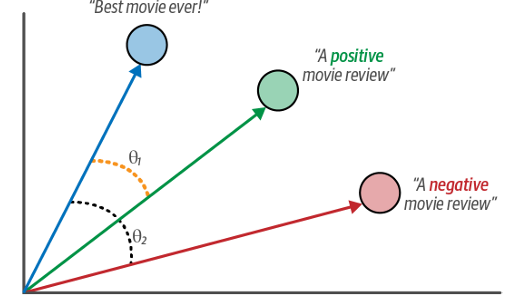

In [117]:
# we give inputs that are to be used as labels
label_embeddings = model.encode(["bad movie", "good movie"])

In [118]:
# apply cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# similarity matrix of negative and positive
sim_matrix = cosine_similarity(test_embed, label_embeddings)

# prediciton
y_pred = torch.argmax(torch.tensor(sim_matrix), axis=1)

In [119]:
accuracy(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

negative Review       0.79      0.76      0.78       533
positive Review       0.77      0.80      0.78       533

       accuracy                           0.78      1066
      macro avg       0.78      0.78      0.78      1066
   weighted avg       0.78      0.78      0.78      1066



# 2. Text classification with Generative Models

We will use text to text tranformer or T5 model which is an encoder decoder model.

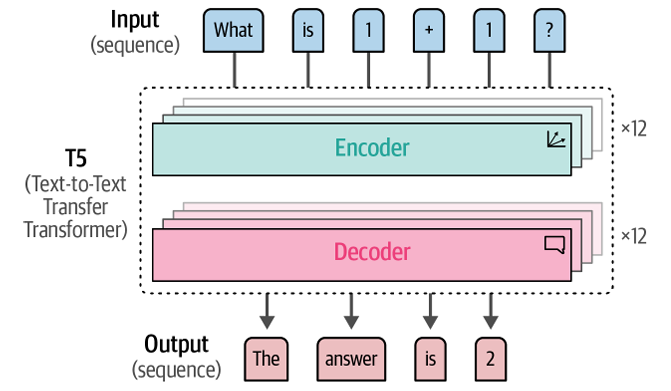

The model is trained using masked landuage modelling by masking set of tokens during pre-training.

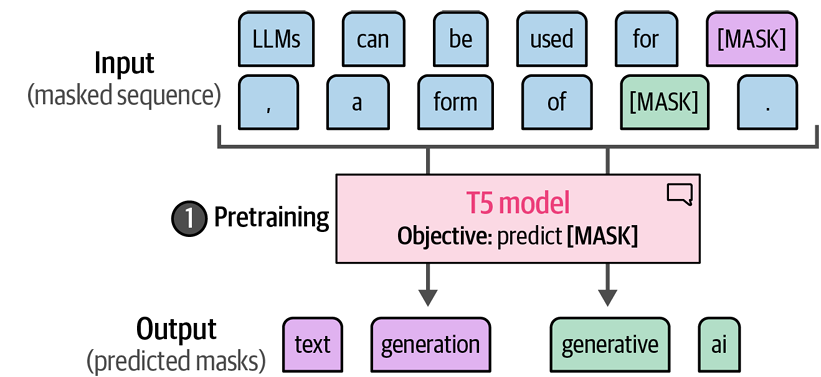

The second step is to fine tune the model for multiple tasks.

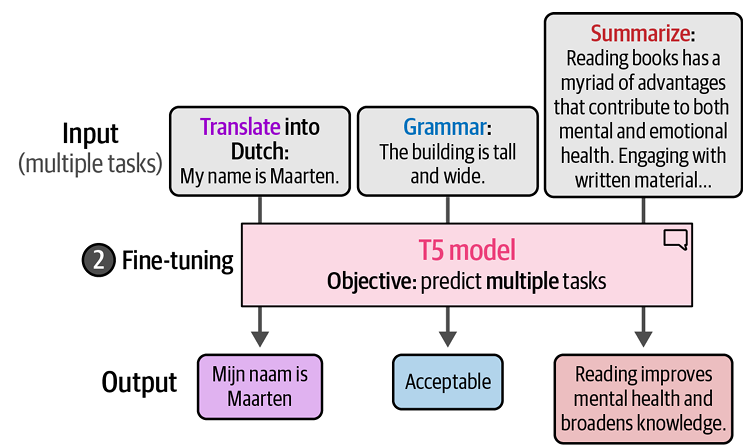

In [122]:
# load the model
pipe = pipeline(
    "text2text-generation",
    model = "google/flan-t5-small",
    device=DEVICE)

Device set to use cuda:0


In [143]:
# prefix the prompt before all the text/document
prompt = "Is the following sentence positive or negative?"

# update the data
data = data.map(lambda instance: {"t5":prompt + instance["text"]})

Map: 100%|███████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 19053.48 examples/s]


In [145]:
# prediction

y_pred = []

for output in tqdm(pipe(KeyDataset(data["test"], "t5")), 
                   total=len(data["test"])):

    # generated text
    text = output[0]["generated_text"]
    
    # prediction label
    y_pred.append(0 if text == "negative" else 1)

100%|██████████████████████████████████████████████████████████████████████████████| 1066/1066 [01:00<00:00, 17.76it/s]


In [146]:
accuracy(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

negative Review       0.83      0.84      0.83       533
positive Review       0.84      0.83      0.83       533

       accuracy                           0.83      1066
      macro avg       0.83      0.83      0.83      1066
   weighted avg       0.83      0.83      0.83      1066

